In [1]:
import requests
import torch
import torch.nn as nn
import os
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset
from typing import Tuple
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import copy
import matplotlib as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


In [3]:
class TaskDataset(Dataset):
    def __init__(self, images, labels):
        self.images = [transform(img) for img in images]
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
public_dataset = torch.load("/content/drive/MyDrive/tml-assignment/Train.pt")
dataset = TaskDataset(public_dataset.imgs, public_dataset.labels)

In [6]:
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
train_size = dataset_size- test_size

In [7]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 85000
Test dataset size: 15000


In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Create the output directory
os.makedirs("/content/drive/MyDrive/tml-assignment/out/models", exist_ok=True)

In [12]:
model_name = 'resnet50'

In [13]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [14]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda")

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-4, weight_decay=8e-4, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

In [16]:
def train(net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for _, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return train_loss/len(train_loader)

In [17]:
def test(net):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    return test_loss/len(test_loader)

In [18]:
import time

In [22]:
train_losses = []
test_losses = []
epochs = 100
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(model)
    test_loss = test(model)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds')
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.2f}%\n')

    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        epochs = epoch+1
        break


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time taken for epoch 1: 87.41 seconds
Epoch 1, Train Loss: 1.1820, Test Loss: 1.0855, Accuracy: 60.46%

Time taken for epoch 2: 87.55 seconds
Epoch 2, Train Loss: 1.0616, Test Loss: 1.0249, Accuracy: 62.74%

Time taken for epoch 3: 87.19 seconds
Epoch 3, Train Loss: 0.9876, Test Loss: 1.0296, Accuracy: 62.54%

Time taken for epoch 4: 87.30 seconds
Epoch 4, Train Loss: 0.9265, Test Loss: 1.0069, Accuracy: 63.66%

Time taken for epoch 5: 88.29 seconds
Epoch 5, Train Loss: 0.8664, Test Loss: 1.0684, Accuracy: 62.32%

Time taken for epoch 6: 87.47 seconds
Epoch 6, Train Loss: 0.8106, Test Loss: 1.0174, Accuracy: 63.92%

Time taken for epoch 7: 86.28 seconds
Epoch 7, Train Loss: 0.7566, Test Loss: 1.0520, Accuracy: 63.52%

Time taken for epoch 8: 88.76 seconds
Epoch 8, Train Loss: 0.7044, Test Loss: 1.0772, Accuracy: 63.14%

Time taken for epoch 9: 87.53 seconds
Epoch 9, Train Loss: 0.6464, Test Loss: 1.1466, Accuracy: 62.12%

Time taken for epoch 10: 87.19 seconds
Epoch 10, Train Loss: 0.5

In [23]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 61 %


In [27]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/tml-assignment/out/models/{model_name}_clean.pt')

In [28]:
import matplotlib.pyplot as plt
import numpy as np


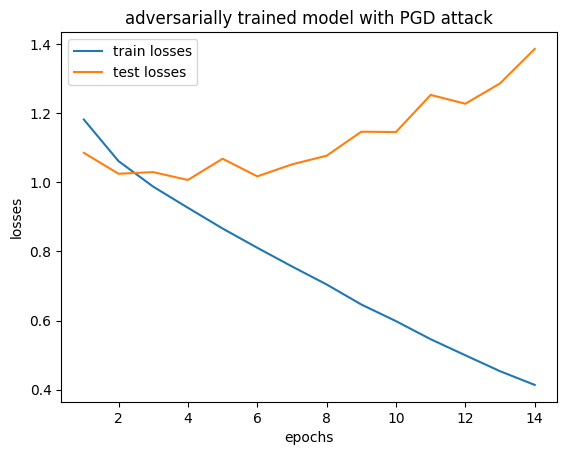

In [29]:
plt.plot(np.arange(1,15),train_losses, label='train losses')
plt.plot(np.arange(1,15), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('adversarially trained model with PGD attack')
plt.legend()
plt.show()

In [36]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
checkpoint = torch.load("/content/drive/MyDrive/tml-assignment/out/models/resnet50_clean.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [39]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda")

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
public_dataset = torch.load("/content/drive/MyDrive/tml-assignment/Train.pt")
dataset = TaskDataset(public_dataset.imgs, public_dataset.labels)

In [42]:
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
train_size = dataset_size- test_size

In [43]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
train_losses = []
test_losses = []
epochs = 100
patience = 5
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(model)
    test_loss = test(model)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds')
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.2f}%\n')

    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        epochs = epoch+1
        break


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time taken for epoch 1: 81.64 seconds
Epoch 1, Train Loss: 0.4845, Test Loss: 0.3814, Accuracy: 88.84%

Time taken for epoch 2: 81.42 seconds
Epoch 2, Train Loss: 0.4873, Test Loss: 0.3803, Accuracy: 88.91%

Time taken for epoch 3: 80.33 seconds
Epoch 3, Train Loss: 0.4839, Test Loss: 0.3884, Accuracy: 88.39%

Time taken for epoch 4: 80.06 seconds
Epoch 4, Train Loss: 0.4868, Test Loss: 0.3870, Accuracy: 88.67%

Time taken for epoch 5: 81.08 seconds
Epoch 5, Train Loss: 0.4859, Test Loss: 0.3771, Accuracy: 88.94%

Time taken for epoch 6: 80.20 seconds
Epoch 6, Train Loss: 0.4826, Test Loss: 0.3777, Accuracy: 89.05%

Time taken for epoch 7: 80.72 seconds
Epoch 7, Train Loss: 0.4870, Test Loss: 0.3941, Accuracy: 88.17%

Time taken for epoch 8: 80.75 seconds
Epoch 8, Train Loss: 0.4837, Test Loss: 0.3717, Accuracy: 89.25%

Time taken for epoch 9: 80.88 seconds
Epoch 9, Train Loss: 0.4831, Test Loss: 0.4130, Accuracy: 87.29%

Time taken for epoch 10: 81.11 seconds
Epoch 10, Train Loss: 0.4

In [45]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/tml-assignment/out/models/{model_name}_clean_addn_transform.pt')

In [46]:
allowed_models = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
}
with open("/content/drive/MyDrive/tml-assignment/out/models/resnet50_clean_addn_transform.pt", "rb") as f:
    try:
        model: torch.nn.Module = allowed_models["resnet50"](weights=None)
        model.fc = torch.nn.Linear(model.fc.weight.shape[1], 10)
    except Exception as e:
        raise Exception(
            f"Invalid model class, {e=}, only {allowed_models.keys()} are allowed",
        )
    try:
        state_dict = torch.load(f, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict, strict=True)
        model.eval()
        out = model(torch.randn(1, 3, 32, 32))
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")

    assert out.shape == (1, 10), "Invalid output shape"


In [47]:
response = requests.post("http://34.71.138.79:9090/robustness", files={"file": open("/content/drive/MyDrive/tml-assignment/out/models/resnet50_clean_addn_transform.pt", "rb")}, headers={"token": "40034445", "model-name":model_name})
print(response.json())

{'clean_accuracy': 0.605, 'fgsm_accuracy': 0.20466666666666666, 'pgd_accuracy': 0.0006666666666666666}
